# Small World Graphs

Code examples from [Think Complexity, 2nd edition](https://thinkcomplex.com).

Copyright 2016 Allen Downey, [MIT License](http://opensource.org/licenses/MIT)

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import seaborn as sns

from utils import decorate, savefig

# I set the random seed so the notebook 
# produces the same results every time.
np.random.seed(17)

# TODO: remove this when NetworkX is fixed
from warnings import simplefilter
import matplotlib.cbook
simplefilter("ignore", matplotlib.cbook.mplDeprecation)

In [2]:
# node colors for drawing networks
colors = sns.color_palette('pastel', 5)
#sns.palplot(colors)
sns.set_palette(colors)

## Regular ring lattice

To make a ring lattice, I'll start with a generator function that yields edges between each node and the next `halfk` neighbors.

In [3]:
def adjacent_edges(nodes, halfk):
    """Yields edges between each node and `halfk` neighbors.
    
    halfk: number of edges from each node
    """
    n = len(nodes)
    for i, u in enumerate(nodes):
        for j in range(i+1, i+halfk+1):
            v = nodes[j % n]
            yield u, v

We can test it with 3 nodes and `halfk=1`

In [4]:
nodes = range(3)
for edge in adjacent_edges(nodes, 1):
    print(edge)

(0, 1)
(1, 2)
(2, 0)


Now we use `adjacent_edges` to write `make_ring_lattice`

In [5]:
def make_ring_lattice(n, k):
    """Makes a ring lattice with `n` nodes and degree `k`.
    
    Note: this only works correctly if k is even.
    
    n: number of nodes
    k: degree of each node
    """
    G = nx.Graph()
    nodes = range(n)
    G.add_nodes_from(nodes)
    G.add_edges_from(adjacent_edges(nodes, k//2))
    return G

And we can test it out with `n=10` and `k=4`

In [6]:
lattice = make_ring_lattice(10, 4)

Saving figure to file figs/chap03-1


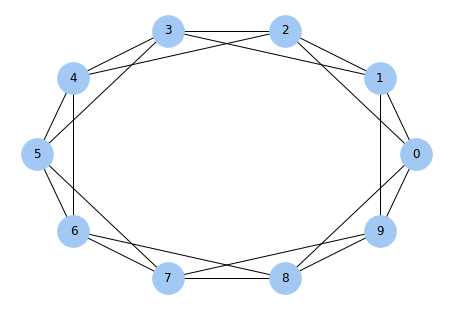

In [7]:
nx.draw_circular(lattice, 
                 node_color='C0', 
                 node_size=1000, 
                 with_labels=True)

savefig('figs/chap03-1')

**Exercise:** To see how this function fails when `k` is odd, run it again with `k=3` or `k=5`.

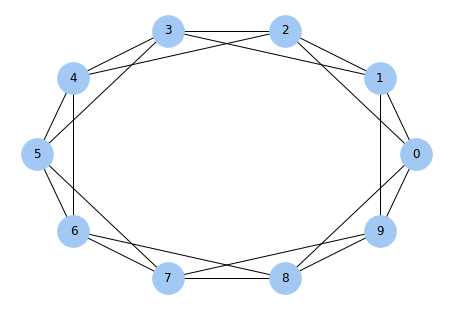

In [8]:
lattice = make_ring_lattice(10, 5) # k is only used as k//2, so it rounds down
nx.draw_circular(lattice, 
                 node_color='C0', 
                 node_size=1000, 
                 with_labels=True)

## WS graph

To make a WS graph, you start with a ring lattice and then rewire.

In [9]:
def make_ws_graph(n, k, p):
    """Makes a Watts-Strogatz graph.
    
    n: number of nodes
    k: degree of each node
    p: probability of rewiring an edge
    """
    ws = make_ring_lattice(n, k)
    rewire(ws, p)
    return ws

Here's the function that does the rewiring

In [10]:
def rewire(G, p):
    """Rewires each edge with probability `p`.
    
    G: Graph
    p: float
    """
    nodes = set(G)
    for u, v in G.edges():
        if flip(p):
            choices = nodes - {u} - set(G[u])
            new_v = np.random.choice(list(choices))
            G.remove_edge(u, v)
            G.add_edge(u, new_v)
            
def flip(p):
    """Returns True with probability `p`."""
    return np.random.random() < p

Here's an example with `p=0.2`

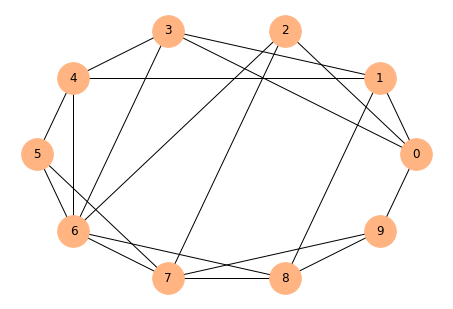

In [11]:
ws = make_ws_graph(10, 4, 0.2)
nx.draw_circular(ws, 
                 node_color='C1', 
                 node_size=1000, 
                 with_labels=True)

Just checking that we have the same number of edges we started with:

In [12]:
len(lattice.edges()), len(ws.edges())

(20, 20)

Now I'll generate a plot that shows WS graphs for a few values of `p`

Saving figure to file figs/chap03-2


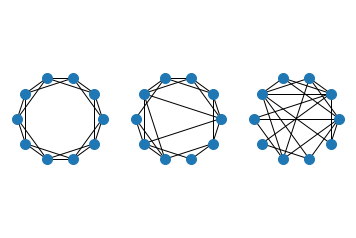

In [13]:
n = 10
k = 4
ns = 100

plt.subplot(1,3,1)
ws = make_ws_graph(n, k, 0)
nx.draw_circular(ws, node_size=ns)
plt.axis('equal')

plt.subplot(1,3,2)
ws = make_ws_graph(n, k, 0.2)
nx.draw_circular(ws, node_size=ns)
plt.axis('equal')

plt.subplot(1,3,3)
ws = make_ws_graph(n, k, 1.0)
nx.draw_circular(ws, node_size=ns)
plt.axis('equal')

#TODO: Set figure size
savefig('figs/chap03-2')

**Exercise:** What is the order of growth of `rewire`?

In [14]:
# Assuming you mean the order of growth of the time it takes to run...
# O(n) where n is the number of edges
# Because, the loop runs n times, and each iteration only does constant-time operations (set operations, random numbers)

## Clustering

The following function computes the local clustering coefficient for a given node, `u`:

In [15]:
def node_clustering(G, u):
    """Computes local clustering coefficient for `u`.
    
    G: Graph
    u: node
    
    returns: float
    """
    neighbors = G[u]
    k = len(neighbors)
    if k < 2:
        return np.nan
        
    possible = k * (k-1) / 2
    exist = 0    
    for v, w in all_pairs(neighbors):
        if G.has_edge(v, w):
            exist +=1
    return exist / possible

def all_pairs(nodes):
    """Generates all pairs of nodes."""
    for i, u in enumerate(nodes):
        for j, v in enumerate(nodes):
            if i < j:
                yield u, v

The network average clustering coefficient is just the mean of the local CCs.

In [16]:
def clustering_coefficient(G):
    """Average of the local clustering coefficients.
    
    G: Graph
    
    returns: float
    """
    cu = [node_clustering(G, node) for node in G]
    return np.nanmean(cu)

In a ring lattice with `k=4`, the clustering coefficient for each node should be 0.5

In [17]:
lattice = make_ring_lattice(10, 4)
node_clustering(lattice, 1)

0.5

And the network average should be 0.5

In [18]:
clustering_coefficient(lattice)

0.5

Correct.

In [19]:
%timeit clustering_coefficient(lattice)

115 µs ± 15.5 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


**Exercise:** Write a version of `node_clustering` that replaces the `for` loop with a list comprehension.  Is it faster?

In [20]:
def node_clustering_lc(G, u): # No faster, it probably "compiles" to the same thing
    """Computes local clustering coefficient for `u`.
    
    G: Graph
    u: node
    
    returns: float
    """
    neighbors = G[u]
    k = len(neighbors)
    if k < 2:
        return np.nan
        
    possible = k * (k-1) / 2
    exist = sum([1 if G.has_edge(v,w) else 0 for v,w in all_pairs(neighbors)])
    return exist / possible

In [21]:
%timeit clustering_coefficient(lattice)

101 µs ± 4.96 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


**Exercise:** What is the order of growth of `clustering_coefficient` in terms of `n`, `m`, and `k`?

In [22]:
# I'm not sure what m is, but n is the number of nodes, and k is the degree of each node.
# O(n*(2^k))
# Because the outer loop runs n times (once per point), and the inner loop (node_clustering)
# runs once per possible pair of neighbors, which is ~2^k for k neighbors.

## Path length

The following function computes path lengths between all pairs of nodes

In [23]:
def path_lengths(G):
    length_iter = nx.shortest_path_length(G)
    for source, dist_map in length_iter:
        for dest, dist in dist_map.items():
            yield dist

The characteristic path length is the mean path length for all pairs.

In [24]:
def characteristic_path_length(G):
    return np.mean(list(path_lengths(G)))

On a complete graph, the average path length should be 1

In [25]:
complete = nx.complete_graph(10)
characteristic_path_length(complete) # Returns 0.9?

0.9

On a ring lattice with `n=1000` and `k=10`, the mean is about 50

In [26]:
lattice = make_ring_lattice(1000, 10)
characteristic_path_length(lattice)

50.4

**Exercise:**  What is the mean path length in a ring lattice with `n=10` and `k=4`?

In [27]:
lattice = make_ring_lattice(10, 4)
characteristic_path_length(lattice) # 1.5

1.5

## The experiment

This function generates a WS graph with the given parameters and returns a pair of (mean path length, clustering coefficient):

In [28]:
def run_one_graph(n, k, p):
    """Makes a WS graph and computes its stats.
    
    n: number of nodes
    k: degree of each node
    p: probability of rewiring
    
    returns: tuple of (mean path length, clustering coefficient)
    """
    ws = make_ws_graph(n, k, p)    
    mpl = characteristic_path_length(ws)
    cc = clustering_coefficient(ws)
    print(mpl, cc)
    return mpl, cc

With `n=1000` and `k=10`, it takes a few seconds on my computer:

In [29]:
%time run_one_graph(1000, 10, 0.01)

8.162078 0.6428959595959596
CPU times: user 4.81 s, sys: 7.97 ms, total: 4.82 s
Wall time: 4.82 s


(8.162078, 0.6428959595959596)

Now we'll run it with a range of values for `p`.

In [30]:
ps = np.logspace(-4, 0, 9)
print(ps)

[1.00000000e-04 3.16227766e-04 1.00000000e-03 3.16227766e-03
 1.00000000e-02 3.16227766e-02 1.00000000e-01 3.16227766e-01
 1.00000000e+00]


This function runs each value of `p` 20 times and returns a dictionary that maps from each `p` to a list of (mpl, cc) pairs.

In [31]:
def run_experiment(ps, n=1000, k=10, iters=20):
    """Computes stats for WS graphs with a range of `p`.
    
    ps: sequence of `p` to try
    n: number of nodes
    k: degree of each node
    iters: number of times to run for each `p`
    
    returns:
    """
    return # Added because I kept running the cell by accident
    res = []
    for p in ps:
        print(p)
        t = [run_one_graph(n, k, p) for _ in range(iters)]
        means = np.array(t).mean(axis=0)
        print(means)
        res.append(means)
    return np.array(res)

Here are the raw results.  Warning: this takes a few minutes to run.

In [32]:
%time res = run_experiment(ps)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.68 µs


In [33]:
res

Let's get the results into a form that's easy to plot.

In [34]:
L, C = np.transpose(res)

TypeError: iteration over a 0-d array

In [35]:
L

NameError: name 'L' is not defined

In [36]:
C

NameError: name 'C' is not defined

And normalize them so they both start at 1.0

In [ ]:
L /= L[0]
C /= C[0]

Here's the plot that replicates Watts and Strogatz's Figure 2.

In [ ]:
plt.plot(ps, C, 's-', linewidth=1, label='C(p) / C(0)')
plt.plot(ps, L, 'o-', linewidth=1, label='L(p) / L(0)')
decorate(xlabel='Rewiring probability (p)', xscale='log',
         title='Normalized clustering coefficient and path length',
         xlim=[0.00009, 1.1], ylim=[-0.01, 1.01])

savefig('figs/chap03-3')

## Breadth-first search

Now let's see how the shortest path algorithm works.  We'll start with BFS, which is the basis for Dijkstra's algorithm.

Here's our old friend, the ring lattice:

In [ ]:
lattice = make_ring_lattice(10, 4)

In [ ]:
nx.draw_circular(lattice, 
                 node_color='C2', 
                 node_size=1000, 
                 with_labels=True)

And here's my implementation of BFS using a deque.

In [37]:
from collections import deque

def reachable_nodes_bfs(G, start):
    """Finds reachable nodes by BFS.
    
    G: graph
    start: node to start at
    
    returns: set of reachable nodes
    """
    seen = set()
    queue = deque([start])
    while queue:
        node = queue.popleft()
        if node not in seen:
            seen.add(node)
            queue.extend(G.neighbors(node))
    return seen

It works:

In [38]:
reachable_nodes_bfs(lattice, 0)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

Here's a version that's a little faster, but maybe less readable.

In [39]:
def reachable_nodes_bfs(G, start):
    """Finds reachable nodes by BFS.
    
    G: graph
    start: node to start at
    
    returns: set of reachable nodes
    """
    seen = set()
    queue = deque([start])
    while queue:
        node = queue.popleft()
        if node not in seen:
            seen.add(node)
            neighbors = set(G[node]) - seen
            queue.extend(neighbors)
    return seen

It works, too.

In [40]:
reachable_nodes_bfs(lattice, 0)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

## Dijkstra's algorithm

Now we're ready for Dijkstra's algorithm, at least for graphs where all the edges have the same weight/length.

In [76]:
def shortest_path_dijkstra(G, source):
    """Finds shortest paths from `source` to all other nodes.
    
    G: graph
    source: node to start at
    
    returns: make from node to path length
    """
    dist = {source: 0}
    queue = deque([source])
    while queue:
        node = queue.popleft()
        new_dist = dist[node] + 1

        neighbors = set(G[node]).difference(dist)
        for n in neighbors:
            dist[n] = new_dist
        
        queue.extend(neighbors)
    return dist

Again, we'll test it on a ring lattice.

In [77]:
lattice = make_ring_lattice(10, 4)
type(lattice)

networkx.classes.graph.Graph

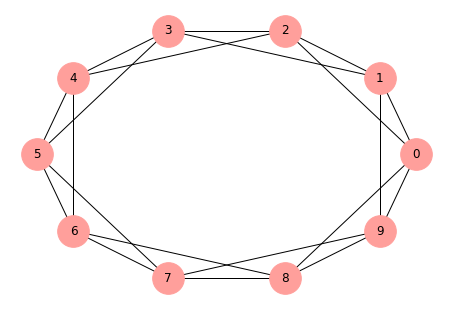

In [78]:
nx.draw_circular(lattice, 
                 node_color='C3', 
                 node_size=1000, 
                 with_labels=True)

Here's my implementation:

In [79]:
d1 = shortest_path_dijkstra(lattice, 0)
d1

{0: 0, 8: 1, 1: 1, 2: 1, 9: 1, 6: 2, 7: 2, 3: 2, 4: 2, 5: 3}

And here's the result from NetworkX:

In [80]:
d2 = nx.shortest_path_length(lattice, 0)
d2

{0: 0, 1: 1, 2: 1, 8: 1, 9: 1, 3: 2, 4: 2, 6: 2, 7: 2, 5: 3}

They are the same:

In [ ]:
d1 == d2

**Exercise:** In a ring lattice with `n=1000` and `k=10`, which node is farthest from 0 and how far is it?  Use `shortest_path_dijkstra` to check your answer.

Note: the maximum distance between two nodes is the **diameter** of the graph.

In [ ]:
# Presumably node 500, which is (500/10=50) steps away, plus or minus some boundary effects.
lattice = make_ring_lattice(1000, 10)
shortest_path_dijkstra(lattice, 0)[500]
# Oh, right, k isn't the number of steps, it's half that.  So I was off by half.

## Exercises

**Exercise:** In a ring lattice, every node has the same number of neighbors.  The number of neighbors is called the **degree** of the node, and a graph where all nodes have the same degree is called a **regular graph**.

All ring lattices are regular, but not all regular graphs are ring lattices.  In particular, if `k` is odd, we can't construct a ring lattice, but we might be able to construct a regular graph.

Write a function called `make_regular_graph` that takes `n` and `k` and returns a regular graph that contains `n` nodes, where every node has `k` neighbors.  If it's not possible to make a regular graph with the given values of `n` and `k`, the function should raise a `ValueError`.

In [ ]:
import math
def make_regular_graph(n,k):
    # First, filter values that won't work
    if n<0 or k<0:
        raise ValueError("can't have a negative number of nodes or edges")
    if k>(n-1):
        raise ValueError("too many edges for the number of nodes")
    if (k%2==1 and n%2==1):
        raise ValueError("either number of edges or number of nodes must be odd")
    
    ring = make_ring_lattice(n,2*math.ceil(k/2))
    if k%2 and k!=(n-1):
        for i in range(0,n,2):
            ring.remove_edge(i,i+1)
    
    return ring

"""
g = make_regular_graph(4,3)
nx.draw_circular(g,  node_color='C3',  node_size=1000,  with_labels=True)
"""

g = make_regular_graph(5,4)
nx.draw_circular(g,  node_color='C3',  node_size=1000,  with_labels=True)

"""
g = make_regular_graph(5,3)
nx.draw_circular(g,  node_color='C3',  node_size=1000,  with_labels=True)
"""

        

**Exercise:** My implementation of `reachable_nodes_bfs` is efficient in the sense that it is in $O(n + m)$, but it incurs a lot of overhead adding nodes to the queue and removing them.  NetworkX provides a simple, fast implementation of BFS, available from [the NetworkX repository on GitHub](https://github.com/networkx/networkx/blob/master/networkx/algorithms/components/connected.py).

Here is a version I modified to return a set of nodes:

In [45]:
def plain_bfs(G, start):
    """A fast BFS node generator"""
    seen = set()
    nextlevel = {start}
    while nextlevel:
        thislevel = nextlevel
        nextlevel = set()
        for v in thislevel:
            if v not in seen:
                seen.add(v)
                nextlevel.update(G[v])
    return seen

Compare this function to `reachable_nodes_bfs` and see which is faster.  Then see if you can modify this function to implement a faster version of `shortest_path_dijkstra`

In [57]:
graph = make_ws_graph(100, 30, 1.0) # I'm too lazy to make a random-graph generator
%timeit reachable_nodes_bfs(graph, 0)
%timeit plain_bfs(graph, 0)
# It looks like plain_bfs is about twice as fast.

814 µs ± 83.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
389 µs ± 4.04 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [58]:
def plain_dijkstra(G, start):
    
    seen = {}
    nextlevel = {start} # aright listen, camelCase is ok, snake_case is ok, but nocase is not.
    current_dist = 0
    while nextlevel:
        thislevel = nextlevel
        nextlevel = set()
        current_dist += 1
        
        for v in thislevel:
            if v not in seen:
                seen[v] = current_dist
                nextlevel.update(G[v])
    return seen

In [59]:
graph = make_ws_graph(100, 30, 1.0) # I'm too lazy to make a random-graph generator
%timeit shortest_path_dijkstra(graph, 0)
%timeit plain_dijkstra(graph, 0)
# The new one is about 30% faster I think

567 µs ± 4.82 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
387 µs ± 14.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


**Exercise:** The following implementation of a BFS contains two performance errors.  What are
they?  What is the actual order of growth for this algorithm?

In [60]:
def bfs(G, start):
    """Breadth-first search on a graph, starting at top_node."""
    visited = set()
    queue = [start]
    while len(queue):
        curr_node = queue.pop(0)    # Dequeue
        visited.add(curr_node)

        # Enqueue non-visited and non-enqueued children
        queue.extend(c for c in G[curr_node]
                     if c not in visited and c not in queue)
    return visited

The performance errors are:
* pop(0) runs in linear time, since Python lists are single-ended (so to speak).  `queue` should be a deque.
* Checking which nodes are enqueued or visited is also linear.  It would be better to keep a set of nodes which are visited-or-enqueued, or just a set that mirrors the queue, so we can look things up in constant time.

The algorithm runs in O(n^3) time in the worst case:
* The while() loop runs n times
* The iterator comprehension runs n times per loop iteration
* `c not in queue` takes n steps, and runs once per iterator comprehension iteration

**Exercise:** In the book, I claimed that Dijkstra's algorithm does not work unless it uses BFS.  Write a version of `shortest_path_dijkstra` that uses DFS and test it on a few examples to see what goes wrong.

In [73]:
def some_path_dijkstra(G, source):
    """Finds... some... paths from `source` to all other nodes.
    
    G: graph
    source: node to start at
    
    returns: make from node to path length
    """
    dist = {source: 0}
    queue = deque([source])
    while queue:
        node = queue.pop()
        new_dist = dist[node] + 1

        neighbors = set(G[node]).difference(dist)
        for n in neighbors:
            dist[n] = new_dist
        
        queue.extend(neighbors)
    return dist

In [82]:
graph = make_ws_graph(100, 30, 1.0) # I'm too lazy to make a random-graph generator
print(some_path_dijkstra(graph, 0))
print(nx.shortest_path_length(graph, 0))
# Well, it sure does something!  Not what it's trying to, but something!

{0: 0, 1: 1, 2: 1, 3: 1, 5: 1, 7: 1, 8: 1, 9: 1, 10: 1, 12: 1, 14: 1, 15: 1, 18: 1, 19: 1, 21: 1, 24: 1, 27: 1, 32: 1, 33: 1, 38: 1, 39: 1, 40: 1, 42: 1, 43: 1, 45: 1, 46: 1, 47: 1, 49: 1, 50: 1, 53: 1, 64: 1, 66: 1, 68: 1, 70: 1, 74: 1, 77: 1, 81: 1, 85: 1, 86: 1, 87: 1, 88: 1, 89: 1, 90: 1, 91: 1, 92: 1, 93: 1, 94: 1, 95: 1, 98: 1, 99: 1, 13: 2, 34: 3, 35: 3, 36: 3, 58: 3, 44: 3, 78: 3, 82: 3, 61: 3, 83: 3, 55: 3, 22: 3, 23: 3, 62: 3, 25: 3, 26: 3, 28: 3, 29: 3, 30: 3, 31: 3, 4: 4, 37: 4, 6: 4, 73: 4, 75: 4, 76: 4, 16: 4, 17: 4, 48: 4, 51: 4, 20: 4, 65: 5, 72: 5, 11: 5, 56: 5, 59: 5, 60: 5, 52: 6, 71: 6, 63: 6, 80: 7, 79: 7, 69: 8, 54: 8, 41: 9, 84: 9, 67: 10, 57: 10, 96: 6, 97: 6}
{0: 0, 14: 1, 15: 1, 85: 1, 86: 1, 87: 1, 88: 1, 89: 1, 90: 1, 91: 1, 92: 1, 93: 1, 94: 1, 95: 1, 40: 1, 43: 1, 33: 1, 5: 1, 98: 1, 64: 1, 99: 1, 18: 1, 77: 1, 32: 1, 42: 1, 81: 1, 9: 1, 74: 1, 24: 1, 70: 1, 27: 1, 1: 1, 2: 1, 3: 1, 7: 1, 8: 1, 10: 1, 12: 1, 19: 1, 21: 1, 38: 1, 39: 1, 45: 1, 46: 1, 47: 1,